### Building a Celebrity Look-Alike Detector with Azure's Face Detect and Python
Notebook accompanying the article on [Practical Business Python](https://pbpython.com/python-face-detect.html)

In [1]:
from pathlib import Path
from urllib.parse import urlparse
import requests
import json
from PIL import Image
from io import BytesIO
from matplotlib import patches
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Define your own subscription key
subscription_key = '7f44794XXXXXXXXXXXXXXX4a8e080b41'
assert subscription_key

In [4]:
# You must use your own URL endpoint that is paired with the subscription key
face_api_url = 'https://northcentralus.api.cognitive.microsoft.com/face/v1.0/detect'
face_api_url_verify = 'https://northcentralus.api.cognitive.microsoft.com/face/v1.0/verify'

In [5]:
# Run a simple example to make sure it all works

In [6]:
image_url = 'https://amp.insider.com/images/5a9878b3267894f3058b4676-640-480.jpg'
headers = {'Ocp-Apim-Subscription-Key': subscription_key}

params = {
    'returnFaceId':
    'true',
    'returnFaceLandmarks':
    'false',
    'returnFaceAttributes':
    'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
}

response = requests.post(face_api_url,
                         params=params,
                         headers=headers,
                         json={"url": image_url})

In [7]:
# Inspect the response to see what data is returned
response.json()

[{'faceId': '691d3dcc-fe66-4114-9906-784d08e073a9',
  'faceRectangle': {'top': 99, 'left': 410, 'width': 125, 'height': 125},
  'faceAttributes': {'smile': 0.012,
   'headPose': {'pitch': -5.1, 'roll': 3.4, 'yaw': -3.5},
   'gender': 'male',
   'age': 30.0,
   'facialHair': {'moustache': 0.1, 'beard': 0.1, 'sideburns': 0.1},
   'glasses': 'NoGlasses',
   'emotion': {'anger': 0.0,
    'contempt': 0.075,
    'disgust': 0.0,
    'fear': 0.0,
    'happiness': 0.012,
    'neutral': 0.913,
    'sadness': 0.0,
    'surprise': 0.0},
   'blur': {'blurLevel': 'medium', 'value': 0.58},
   'exposure': {'exposureLevel': 'goodExposure', 'value': 0.7},
   'noise': {'noiseLevel': 'medium', 'value': 0.48},
   'makeup': {'eyeMakeup': True, 'lipMakeup': False},
   'accessories': [],
   'occlusion': {'foreheadOccluded': False,
    'eyeOccluded': False,
    'mouthOccluded': False},
   'hair': {'bald': 0.02,
    'invisible': False,
    'hairColor': [{'color': 'brown', 'confidence': 1.0},
     {'color': 'red

In [8]:
# Define the helper function to annotate the images

In [9]:
def annotate_image(image_url, subscription_key, api_url, show_face_id=False):
    """ Helper function for Microsoft Azure face dectector. 
    
    Args:
        image_url: Can be a remote http://  or file:// url pointing to an image less then 10MB
        subscription_key: Cognitive services generated key
        api_url: API end point from Cognitive services
        show_face_id: If True, display the first 6 characters of the faceID
        
    Returns:
        figure: matplotlib figure that contains the image and boxes around the faces with their age and gender
        json response: Full json data returned from the API call
        
    """

    # The default header must include the sunbscription key
    headers = {'Ocp-Apim-Subscription-Key': subscription_key}

    params = {
        'returnFaceId': 'true',
        'returnFaceLandmarks': 'false',
        'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
    }

    # Figure out if this is a local file or url
    parsed_url = urlparse(image_url)
    if parsed_url.scheme == 'file':
        image_data = open(parsed_url.path, "rb").read()
        
        # When making the request, we need to add a Content-Type Header
        # and pass data instead of a url
        headers['Content-Type']='application/octet-stream'
        response = requests.post(api_url, params=params, headers=headers, data=image_data)
        
        # Open up the image for plotting
        image = Image.open(parsed_url.path)
    else:
        # Pass in the URL to the API
        response = requests.post(api_url, params=params, headers=headers, json={"url": image_url})
        image_file = BytesIO(requests.get(image_url).content)
        image = Image.open(image_file)
    
    faces = response.json()
    
    fig, ax = plt.subplots(figsize=(10,10))

    ax.imshow(image, alpha=0.6)
    for face in faces:
        fr = face["faceRectangle"]
        fa = face["faceAttributes"]
        origin = (fr["left"], fr["top"])
        p = patches.Rectangle(origin, fr["width"], 
                              fr["height"], fill=False, linewidth=2, color='b')
        ax.axes.add_patch(p)
        ax.text(origin[0], origin[1], "%s, %d"%(fa["gender"].capitalize(), fa["age"]), 
                 fontsize=16, weight="bold", va="bottom")
        
        if show_face_id:
            ax.text(origin[0], origin[1]+fr["height"], "%s"%(face["faceId"][:5]), 
             fontsize=12, va="bottom")
    ax.axis("off")
    
    # Explicitly closing image so it does not show in the notebook
    plt.close()
    return fig, faces

In [10]:
# Another helper function to compare faces

In [11]:
def face_compare(id_1, id_2, api_url):
    """ Determine if two faceIDs are for the same person   
    Args:
        id_1: faceID for person 1
        id_2: faceID for person 2
        api_url: API end point from Cognitive services
        show_face_id: If True, display the first 6 characters of the faceID
        
    Returns:
        json response: Full json data returned from the API call
        
    """
    headers = {
        'Content-Type': 'application/json',
        'Ocp-Apim-Subscription-Key': subscription_key
    }

    body = {"faceId1": id_1, "faceId2": id_2}

    params = {}
    response = requests.post(api_url,
                             params=params,
                             headers=headers,
                             json=body)
    return response.json()

In [12]:
# Let's test this out on an image
labeled_image_1, response_1 = annotate_image(
    'https://amp.insider.com/images/5a9878b3267894f3058b4676-640-480.jpg',
    subscription_key,
    face_api_url,
    show_face_id=True)

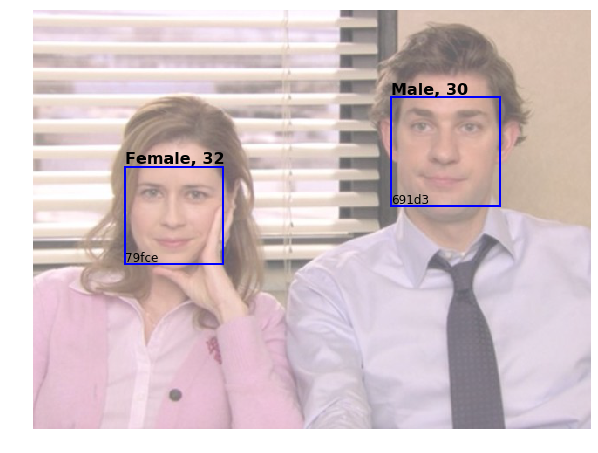

In [13]:
labeled_image_1

In [14]:
response_1

[{'faceId': '691d3dcc-fe66-4114-9906-784d08e073a9',
  'faceRectangle': {'top': 99, 'left': 410, 'width': 125, 'height': 125},
  'faceAttributes': {'smile': 0.012,
   'headPose': {'pitch': -5.1, 'roll': 3.4, 'yaw': -3.5},
   'gender': 'male',
   'age': 30.0,
   'facialHair': {'moustache': 0.1, 'beard': 0.1, 'sideburns': 0.1},
   'glasses': 'NoGlasses',
   'emotion': {'anger': 0.0,
    'contempt': 0.075,
    'disgust': 0.0,
    'fear': 0.0,
    'happiness': 0.012,
    'neutral': 0.913,
    'sadness': 0.0,
    'surprise': 0.0},
   'blur': {'blurLevel': 'medium', 'value': 0.58},
   'exposure': {'exposureLevel': 'goodExposure', 'value': 0.7},
   'noise': {'noiseLevel': 'medium', 'value': 0.48},
   'makeup': {'eyeMakeup': True, 'lipMakeup': False},
   'accessories': [],
   'occlusion': {'foreheadOccluded': False,
    'eyeOccluded': False,
    'mouthOccluded': False},
   'hair': {'bald': 0.02,
    'invisible': False,
    'hairColor': [{'color': 'brown', 'confidence': 1.0},
     {'color': 'red

In [15]:
# Print out some of the attributes
print(response_1[0]['faceId'], response_1[0]['faceAttributes']['emotion'])

691d3dcc-fe66-4114-9906-784d08e073a9 {'anger': 0.0, 'contempt': 0.075, 'disgust': 0.0, 'fear': 0.0, 'happiness': 0.012, 'neutral': 0.913, 'sadness': 0.0, 'surprise': 0.0}


In [16]:
# Take a look at all the face attributes available
response_1[0]['faceAttributes']

{'smile': 0.012,
 'headPose': {'pitch': -5.1, 'roll': 3.4, 'yaw': -3.5},
 'gender': 'male',
 'age': 30.0,
 'facialHair': {'moustache': 0.1, 'beard': 0.1, 'sideburns': 0.1},
 'glasses': 'NoGlasses',
 'emotion': {'anger': 0.0,
  'contempt': 0.075,
  'disgust': 0.0,
  'fear': 0.0,
  'happiness': 0.012,
  'neutral': 0.913,
  'sadness': 0.0,
  'surprise': 0.0},
 'blur': {'blurLevel': 'medium', 'value': 0.58},
 'exposure': {'exposureLevel': 'goodExposure', 'value': 0.7},
 'noise': {'noiseLevel': 'medium', 'value': 0.48},
 'makeup': {'eyeMakeup': True, 'lipMakeup': False},
 'accessories': [],
 'occlusion': {'foreheadOccluded': False,
  'eyeOccluded': False,
  'mouthOccluded': False},
 'hair': {'bald': 0.02,
  'invisible': False,
  'hairColor': [{'color': 'brown', 'confidence': 1.0},
   {'color': 'red', 'confidence': 0.59},
   {'color': 'blond', 'confidence': 0.27},
   {'color': 'black', 'confidence': 0.17},
   {'color': 'gray', 'confidence': 0.05},
   {'color': 'other', 'confidence': 0.01}]}}

In [17]:
# Now compare a different image
john_k_2 = 'https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/magazine/2018/05_2018/john_krasinski_magazine/650x350_john_krasinski_magazine.jpg'
labeled_image_2, response_2 = annotate_image(john_k_2,
                                             subscription_key,
                                             face_api_url,
                                             show_face_id=True)

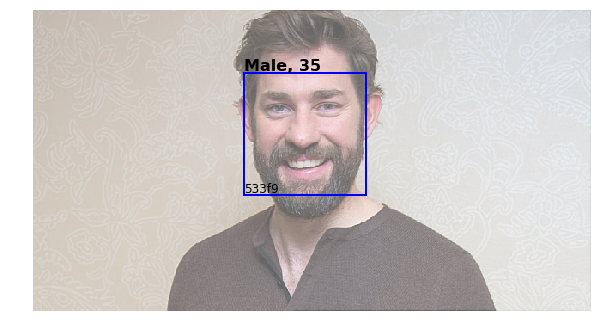

In [18]:
labeled_image_2

In [19]:
# Let's compare the images of John K
face_compare(response_1[0]['faceId'], response_2[0]['faceId'], face_api_url_verify)

{'isIdentical': True, 'confidence': 0.63733}

In [20]:
# Let's try on the celebrity lookalikes
zooey_katy = 'https://www.nydailynews.com/resizer/vboKUbzNIwhFRFfr-jGqZlmx0Ws=/800x597/top/arc-anglerfish-arc2-prod-tronc.s3.amazonaws.com/public/VE7PI5PUDWW2BTS7NYR5OWEL3A.jpg'
labeled_image_z_k, response_4 = annotate_image(zooey_katy,
                                                      subscription_key,
                                                      face_api_url,
                                                      show_face_id=False)

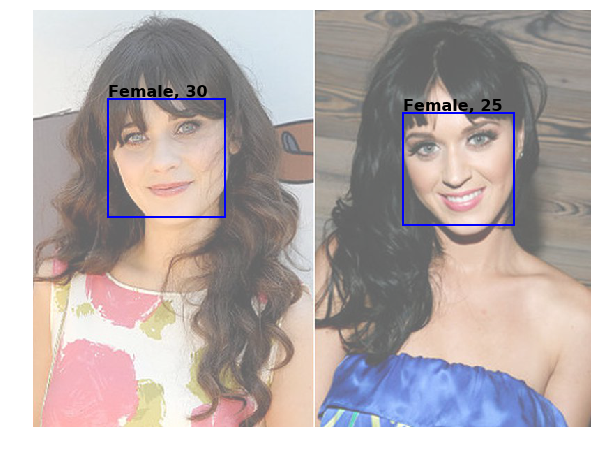

In [21]:
labeled_image_z_k

In [22]:
face_compare(response_4[0]['faceId'], response_4[1]['faceId'],
             face_api_url_verify)

{'isIdentical': False, 'confidence': 0.35506}

In [23]:
# How about a more challenging one?
rob_lowe = 'http://cdn.ppcorn.com/wp-content/uploads/sites/14/2015/08/rob-ian-ppcorn-760x500.jpg'
labeled_image_rob, response_5 = annotate_image(rob_lowe, subscription_key,
                                               face_api_url)

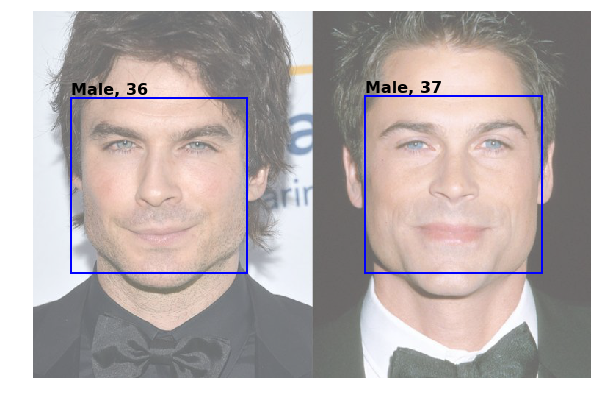

In [24]:
labeled_image_rob

In [25]:
# Looks like we truly can't tell these two apart!
face_compare(response_5[0]['faceId'], response_5[1]['faceId'],
             face_api_url_verify)

{'isIdentical': True, 'confidence': 0.50762}

In [26]:
# Run this on a group of people
friends_url = 'https://pmctvline2.files.wordpress.com/2019/03/friends-revival.jpg'
labeled_image, response_6 = annotate_image(friends_url, subscription_key,
                                           face_api_url)

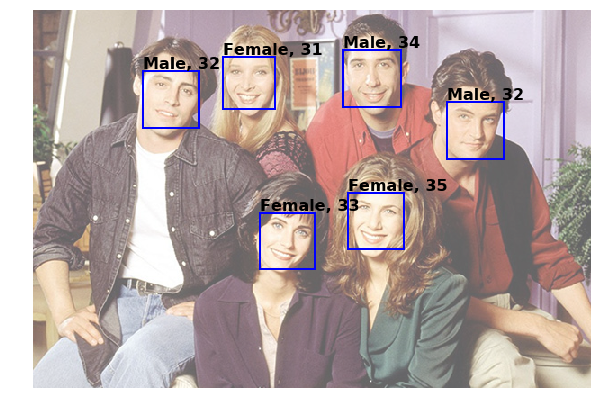

In [27]:
labeled_image

In [28]:
# How many people in the picture?
print(f'{len(response_6)} People in this picture')

6 People in this picture


In [29]:
# Sometimes groups don't work as well
office_image = 'https://www.usmagazine.com/wp-content/uploads/2018/12/the-office-cast-reunion-brunch-photo.jpg?w=768&h=512'
labeled_image, response_7 = annotate_image(office_image, subscription_key,
                                              face_api_url)

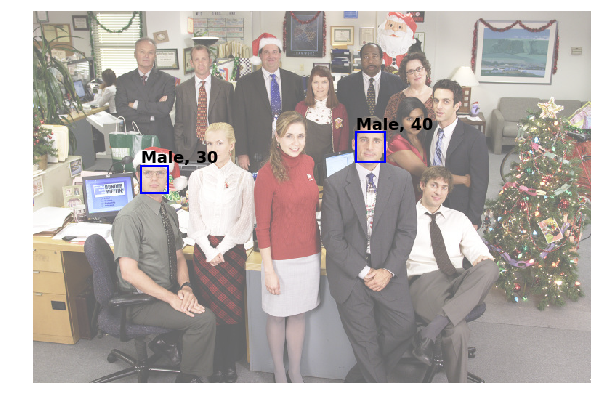

In [30]:
labeled_image

In [31]:
print(f'{len(response_7)} People in this picture')

2 People in this picture
